In [1]:
base_dir = '../../../../1.YL/HWs/Required-files-for-projects/Datasets/2.PEOPLE/filtered'  # Directory containing class folders
target_count = 1000  # Target number of images per class

In [2]:
import os
import random, numpy as np
import cv2
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

2024-06-09 23:03:20.617951: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 23:03:20.651675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 23:03:21.231078: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
def rotate_image(image_path, degrees):
    """Rotate the image by a specific degree and return it."""
    try:
        with Image.open(image_path) as img:
            rotated = img.rotate(degrees, expand=True, fillcolor=tuple(np.mean(np.array(img)[0,:], axis=0).astype(int)))
            # rotated = img.rotate(degrees, expand=True)
            return rotated
    except Exception as e:
        print(f"Error rotating image {image_path}: {e}")
        return None

def augment_images(input_dir, output_dir, target_count):
    """Augment images in the input directory to reach the target count, saving them to the output directory."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = [f for f in os.listdir(input_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
    current_count = len(images)
    augment_count = target_count - current_count

    print(f"Class {os.path.basename(input_dir)} - Current count: {current_count}, Augmenting {augment_count} images to reach {target_count}.")

    for i in range(augment_count):
        img_name = random.choice(images)
        img_path = os.path.join(input_dir, img_name)
        degrees = random.uniform(0, 360)  # Random rotation degree between 0 and 360

        rotated_img = rotate_image(img_path, degrees)
        if rotated_img is not None:
            # Convert image to RGB if it's in RGBA or P mode
            if rotated_img.mode in ['RGBA', 'P']:
                rotated_img = rotated_img.convert('RGB')
            new_img_name = f"{os.path.splitext(img_name)[0]}_rotated_{i}.jpg"
            rotated_img.save(os.path.join(output_dir, new_img_name))

def main():
    for class_name in os.listdir(base_dir):
        input_class_dir = os.path.join(base_dir, class_name)
        output_class_dir = os.path.join(base_dir, class_name + '_augmented')

        if os.path.isdir(input_class_dir):
            augment_images(input_class_dir, output_class_dir, target_count)

if __name__ == "__main__":
    main()


Class angry - Current count: 982, Augmenting 18 images to reach 1000.
Class afraid - Current count: 964, Augmenting 36 images to reach 1000.
Class disgusted - Current count: 989, Augmenting 11 images to reach 1000.
Class happy - Current count: 996, Augmenting 4 images to reach 1000.
Class sad - Current count: 997, Augmenting 3 images to reach 1000.
Class surprised - Current count: 997, Augmenting 3 images to reach 1000.


In [6]:
import imghdr
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(base_dir): 
    for image in os.listdir(os.path.join(base_dir, image_class)):
        image_path = os.path.join(base_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

/tmp/ipykernel_1702/1935981673.py:1: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
data = tf.keras.utils.image_dataset_from_directory(base_dir)

Found 5925 files belonging to 6 classes.


2024-06-09 23:03:31.112133: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: fedora
2024-06-09 23:03:31.112154: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: fedora
2024-06-09 23:03:31.112238: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-06-09 23:03:31.112263: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.78.0


In [ ]:
tf.config.list_physical_devices('GPU') 

In [4]:
data.class_names

['afraid', 'angry', 'disgusted', 'happy', 'sad', 'surprised']

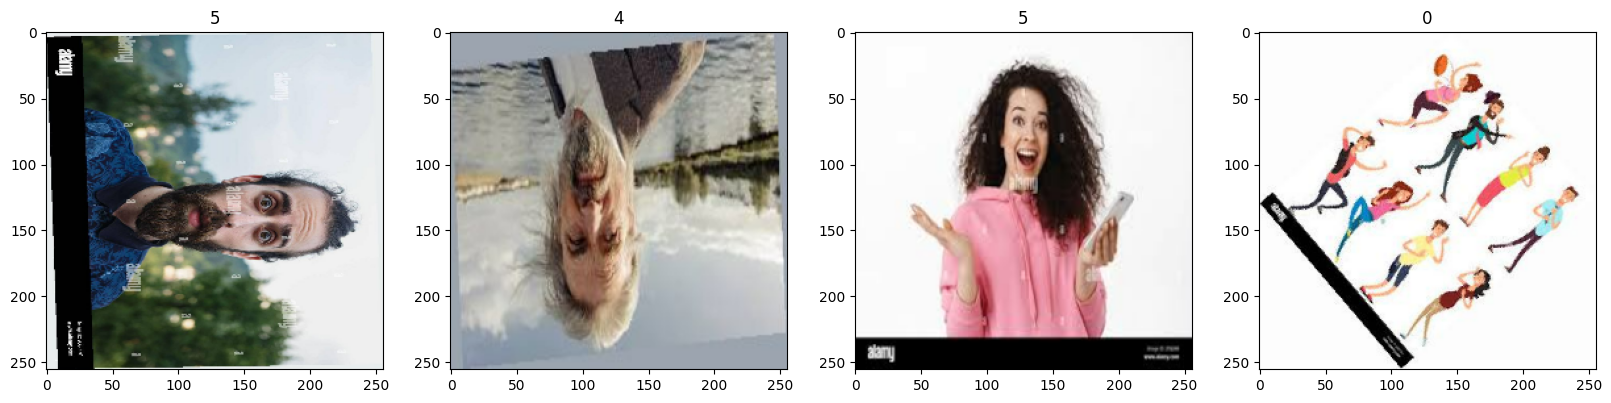

In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
data = data.map(lambda x,y: (x/255, y))

In [7]:
data.as_numpy_iterator().next()

(array([[[[3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          ...,
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01]],
 
         [[3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          ...,
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01]],
 
         [[3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          ...,
          [3.0588236e-01, 3.4117648e-01, 1.1764706e-01],
          [3.0588236e-01, 3.4117648e-

In [8]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [9]:
train_size

130

In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [11]:
model = Sequential()

In [12]:
# model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)), dropout=0.2, padding='same', strides=2)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [22]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

AttributeError: module 'tensorflow.keras' has no attribute 'Precision'

In [23]:
hist = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5


2024-06-09 23:21:14.795924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [1,192] vs. [1,32]
	 [[{{function_node __inference_one_step_on_data_18326}}{{node LogicalAnd}}]]


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_2323/839258024.py", line 1, in <module>

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 106, in one_step_on_data

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 77, in train_step

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 376, in compute_metrics

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 330, in update_state

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 17, in update_state

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/metrics/confusion_metrics.py", line 378, in update_state

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/metrics/metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/metrics/metrics_utils.py", line 565, in weighted_assign_add

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 3357, in logical_and

  File "/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 1194, in logical_and

Incompatible shapes: [1,192] vs. [1,32]
	 [[{{node LogicalAnd}}]] [Op:__inference_one_step_on_iterator_18415]

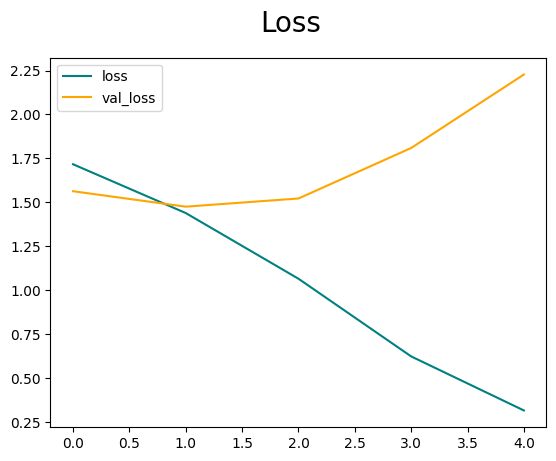

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

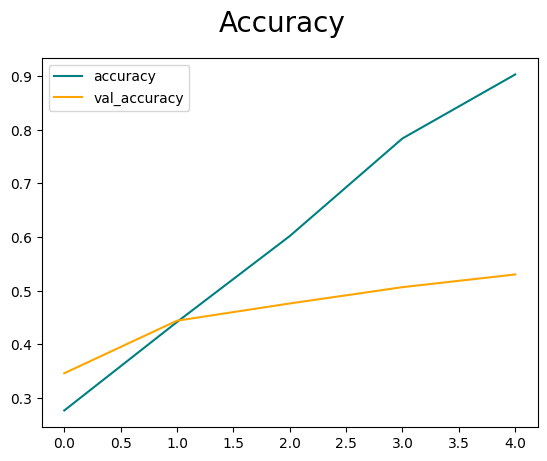

In [25]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
img = cv2.imread('img.png')
plt.imshow(img)
plt.show()

In [ ]:
resized_image = tf.image.resize(img, (256,256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [ ]:
pred = model.predict(np.expand_dims(resized_image/255, 0))

In [ ]:
pred

### Save the Model

In [ ]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','imageclassifier.keras'))

In [ ]:
new_model = load_model('models/imageclassifier.keras')
new_model.predict(np.expand_dims(resized_image/255, 0))